# High Energy Photon Cooling

In this notebook, we demonstrate how the high energy photon cooling works and run some cross checks. 

## Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [4]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

import darkhistory.low_energy.lowE_photons as lowE_photons
import darkhistory.low_energy.lowE_electrons as lowE_electrons

import scipy.interpolate

np.set_printoptions(threshold=np.nan)

## Load Reference Results

These reference results start with a delta-function like injection at a redshift of $(1+z) = 31$ of 2 photons at the energy given by the file name. The high energy photons are stored in `file_photonspectrum`, low energy photons in `file_lowengphot` and low energy electrons in `file_lowengelec`. The photon energy abscissa is `file_eng` (both high and low) while the electron energy abscissa is `file_eleceng`. 

In [5]:
user = 'gridgway'

new_data=False
eng_ind = 299
eng_exp = {19: 3.491, 99: 5.328, 199: 7.183, 299: 9.038}[eng_ind]#7.183#9.038#5.328

# Check that this matches with the input 

file_name = {19: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_3.491E+00_xe_1.000E-04.fits",
            99: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits",
            399: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

if new_data:
    file_name[99]  = "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ref_files/contdep-logE05.327-z0031-0010-delta-comptdetail-FSR-single-zstopinject-9.9975652-partition-3.47712-comptonsmooth-modifiedheat-modifiedion-depositiondetailed-heliumseparated-planckparams.fits"
    file_name[199] = "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ref_files/contdep-logE07.187-z0031-0010-delta-comptdetail-FSR-single-zstopinject-9.9975652-partition-3.47712-comptonsmooth-modifiedheat-modifiedion-depositiondetailed-heliumseparated-planckparams.fits"
    file_name[299] = "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ref_files/contdep-logE09.047-z0031-0010-delta-comptdetail-FSR-single-zstopinject-9.9975652-partition-3.47712-comptonsmooth-modifiedheat-modifiedion-depositiondetailed-heliumseparated-planckparams.fits"
    eng_exp = {99: 5.32665, 199: 7.18686, 299: 9.04706}[eng_ind]
print(eng_exp)
    
file = fits.open(file_name[eng_ind])

file_eng =            file[1].data['energy'][0,:]
file_eleceng =        file[1].data['eleceng'][0,:]
file_rs =             file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]
file_lowengphot =     file[1].data['lowengphot'][0,:,:]
file_lowengelec =     file[1].data['lowengelec'][0,:,:]
file_engloss =        file[1].data['cmblosstable'][0,:]
file_xes =            file[1].data['hionfraction'][0,:]

9.038


Turn the data into `Spectra` objects. 

In [6]:
std_soln = pickle.load(open('/Users/gridgway/Dropbox (MIT)/21cm_pwave/'+
                            'TLA_code/examples/old_notebooks/standard_soln.p','rb'))
std_soln_rs = std_soln[0]
std_soln_T = std_soln[1]
std_soln_xe = std_soln[2]

if  new_data:
    std_xe_interp = scipy.interpolate.interp1d(file_rs, file_xes)
else:
    std_xe_interp = scipy.interpolate.interp1d(std_soln_rs[2967:], std_soln_xe[2967:])

In [7]:
file_highengphot_spectra = Spectra([Spectrum(file_eng, photspec, rs=rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

file_lowengphot_spectra = Spectra([Spectrum(file_eng, photspec, rs=rs) 
                   for photspec,rs in zip(file_lowengphot, file_rs)])

file_lowengelec_spectra = Spectra([Spectrum(file_eleceng, elecspec, rs=rs) 
                   for elecspec,rs in zip(file_lowengelec, file_rs)])

### Transfer Method Comparison: coarse rs bin check 

In [8]:
%autoreload
m_chi = 10**eng_exp
d_lnz = 1e-3
min_indx = 6

# List of redshifts from the Mathematica file
math_rs_list = np.loadtxt("/Users/"+user+"/Desktop/tmp.dat")[min_indx:]
math_rs_bounds = spectools.get_bin_bound(math_rs_list)

rs_list = file_lowengphot_spectra.rs
eng = file_lowengphot_spectra.eng
eng_bounds = spectools.get_bin_bound(eng)

# xe as a function of redshift
xes = std_xe_interp(rs_list)

#Ensure that electron and photon spectra occur at the same redshifts
if np.any(np.abs(rs_list - file_lowengelec_spectra.rs) > 1e-6):
    sys.exit()
    
# indx at which photons can photoionize
ion_indx = spectools.get_indx(eng,phys.rydberg)

# max index at which math_rs_bounds fits in rs_list
max_indx = spectools.get_indx(math_rs_list, rs_list[0])
f_list = np.zeros([max_indx+1,5])

#to calculate cmb_loss
def CMB_dNdE(eng):
    return phys.CMB_spec(eng,T)

#initialize loop
indx2 = len(rs_list) - np.searchsorted(np.flipud(rs_list), math_rs_bounds[0]) - 1

# Sum all spectra between redshifts rs_list[k] and rs_list[k+1]
for k in np.arange(max_indx+1):
    indx1 = len(rs_list) - np.searchsorted(np.flipud(rs_list), math_rs_bounds[k+1])
    
    #Do I coarse grain correctly?
    #print(k, ' ', math_rs_bounds[k], 
    #      ' ', rs_list[indx2], ' ', rs_list[indx1], ' ', math_rs_bounds[k+1])
    weights = np.zeros(len(rs_list))
    weights[indx1 : indx2 + 1] = 1
    loweng_phot = file_lowengphot_spectra.sum_specs(weights)
    loweng_phot.rs=1
    
    loweng_elec = file_lowengelec_spectra.sum_specs(weights)
    
    #Include an energy of 10^-12 with occupation zero
    loweng_elec = Spectrum(
        np.insert(loweng_elec.eng, 0, 1e-12), np.insert(loweng_elec.N, 0, 0),
        rs=1, spec_type='N'
    )
    
    # ionized electrons
    tmp_elec = Spectrum(
        loweng_phot.eng[ion_indx:], loweng_phot.N[ion_indx:], rs=1, spec_type='N'
    )
    new_eng = tmp_elec.eng - phys.rydberg
    
    if new_eng[0] < 0:
        #Don't allow negative energies
        new_eng = np.insert(new_eng[1:], 0, 1e-12)
    tmp_elec.shift_eng(new_eng)

    # rebin so that I may add it to loweng_elec
    indx = tmp_elec.eng.size
    tmp_elec.rebin(loweng_elec.eng[:indx+1])
    loweng_elec.N[:indx+1] += tmp_elec.N
    
    # Compute Transfer Functions
    T_phot = lowE_photons.compute_dep_inj_ratio(
        loweng_phot, np.array([1-xes[k], 0, 0]), 1, 1, 'old'
    )/phys.nB/(2*m_chi+0*phys.me)

    T_elec = lowE_electrons.compute_dep_inj_ratio(
        loweng_elec, xes[k], 1, 1
    )/phys.nB/(2*m_chi+0*phys.me)
    
    f_list[k] = T_phot + T_elec
    
    #subtract off the CMB part contributing to continuum photons
    f_list[k,0] -= sum(file_engloss[indx1: indx2 + 1] * d_lnz /(
        phys.hubble(rs_list[indx1: indx2 + 1]) * 2 * m_chi
    ))
    
    indx2 = indx1-1
    
print('cont, exc, HI ion, He ion, heat: ',sum(f_list))

cont, exc, HI ion, He ion, heat:  [4.30720384e-04 6.25786787e-04 8.40203215e-04 3.25378430e-05
 3.80387926e-04]


../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [9]:
old_tfs = np.loadtxt("/Users/"+user+"/Desktop/tmp"+str(eng_ind)+".dat")[min_indx:]
print(len(old_tfs))
print('mine: ',sum(sum(f_list)))
print('hers: ',sum(sum(old_tfs)))

13
mine:  0.0023096361550853607
hers:  0.002345851581367242


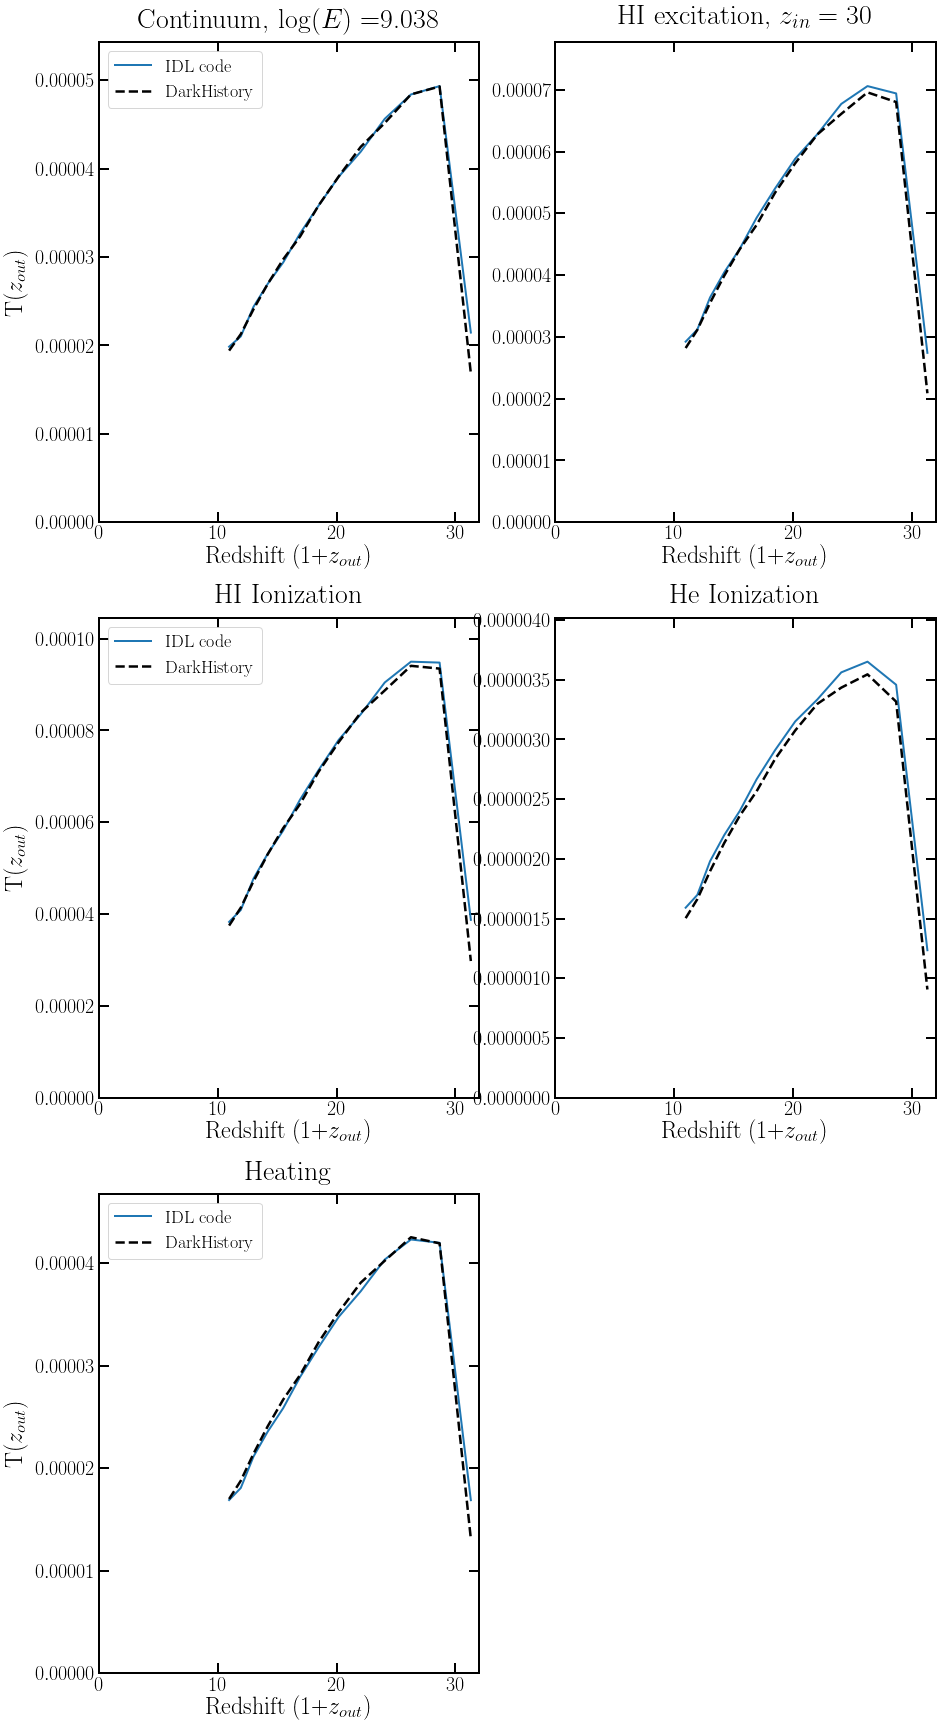

In [10]:
old_tfs = np.loadtxt("/Users/"+user+"/Desktop/tmp"+str(eng_ind)+".dat")[min_indx:]

plt.figure(figsize=(15,30))

names = ["Continuum", "HI excitation", "HI Ionization", "He Ionization", "Heating"]

for num in np.arange(5):

    ax = plt.subplot(3,2,num+1)

    old_tf_plt, = plt.plot(math_rs_list[:max_indx+1], old_tfs[:,num], linewidth=2, label='IDL code')
    new_tf_plt, = plt.plot(math_rs_list[:max_indx+1], f_list[:,num], 'k--', label='DarkHistory')

    #ax.set_xscale('log')
    #ax.set_yscale('log')

    plt.tick_params(axis='both', which='major', labelsize=20)

    if num == 0:
        plt.title(names[num]+', $\\log(E) = $'+str(eng_exp), fontsize=28)
    elif num == 1:
        plt.title(names[num]+', $z_{in} = 30$', fontsize=28)
    else:
        plt.title(names[num], fontsize=28)
    plt.xlabel('Redshift (1+$z_{out}$)',fontsize=24)
    if num%2 == 0:
        plt.ylabel('T($z_{out}$)',fontsize=24)
        plt.legend(handles=[old_tf_plt, new_tf_plt], 
            fontsize=18)
    plt.axis(
        [0, 32, 0, 1.1 * max(
            [max(f_list[:,num]),max(old_tfs[:,num])]
        )]
    )

if new_data:
    extra = 'better_xe'
else:
    extra = ''
plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/'+
            'Reproducing_tFuncs_log10(E)_'+str(eng_exp)+'_'+extra+'.pdf')

## Photon Cooling

These reference results start with a delta-function like injection at a redshift of $(1+z) = 31$ of 2 photons at the energy given by the file name. The high energy photons are stored in `file_photonspectrum`, low energy photons in `file_lowengphot` and low energy electrons in `file_lowengelec`. The photon energy abscissa is `file_eng` (both high and low) while the electron energy abscissa is `file_eleceng`. 

In [119]:
user = 'gridgway'

eng_ind = 299
eng_exp = {19: 3.491, 99: 5.328, 199: 7.183, 299: 9.038}[eng_ind]#7.183#9.038#5.328

file_name = {19: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_3.491E+00_xe_1.000E-04.fits",
            99: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits",
            399: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}
    
file = fits.open(file_name[eng_ind])

file_eng =            file[1].data['energy'][0,:]
file_eleceng =        file[1].data['eleceng'][0,:]
file_rs =             file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]
file_lowengphot =     file[1].data['lowengphot'][0,:,:]
file_lowengelec =     file[1].data['lowengelec'][0,:,:]
file_engloss =        file[1].data['cmblosstable'][0,:]
file_xes =            file[1].data['hionfraction'][0,:]

import scipy.interpolate

std_soln = pickle.load(open('/Users/gridgway/Dropbox (MIT)/21cm_pwave/'+
                            'TLA_code/examples/old_notebooks/standard_soln.p','rb'))
std_soln_rs = std_soln[0]
std_soln_xe = std_soln[2]

std_xe_interp = scipy.interpolate.interp1d(std_soln_rs[2967:], std_soln_xe[2967:])

Turn the data into `Spectra` objects. 

In [120]:
file_highengphot_spectra_raw = Spectra([Spectrum(file_eng, photspec, rs=rs) 
    for photspec,rs in zip(file_photonspectrum, file_rs)])

file_lowengphot_spectra_raw = Spectra([Spectrum(file_eng, photspec, rs=rs) 
    for photspec,rs in zip(file_lowengphot, file_rs)])

file_lowengelec_spectra_raw = Spectra([Spectrum(file_eleceng, elecspec, rs=rs) 
    for elecspec,rs in zip(file_lowengelec, file_rs)])

Now we cool the photons that result from the high energy photon injection. Photons below 3.1 keV are considered low energy photons. For high energy photons, greater than 3.1 keV, we have transfer functions into high energy photons, low energy photons and low energy electrons. Let's load them first. These are saved as arrays of `TransFuncList` objects, for a list of 10 different levels of $x_e$.

In [121]:
highengphot_tflist_arr_raw = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_list.raw", "rb"))
lowengphot_tflist_arr_raw  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_list.raw", "rb"))
lowengelec_tflist_arr_raw  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_list.raw", "rb"))

For checks, we may want to use just one particular set of transfer functions. If so, we should run this cell.

In [122]:
tflist_xe_ind = 1

print(0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4]))

highengphot_tflist_arr = [highengphot_tflist_arr_raw[tflist_xe_ind]]
lowengphot_tflist_arr  = [lowengphot_tflist_arr_raw[tflist_xe_ind]]
lowengelec_tflist_arr  = [lowengelec_tflist_arr_raw[tflist_xe_ind]]

[4.53978687e-05 2.74578156e-04 1.65880108e-03 9.95180187e-03
 5.73241759e-02 2.68941421e-01 6.89974481e-01 9.30861580e-01
 9.87871565e-01 9.97974680e-01 9.99664650e-01]


## Inputs

Next, we define the input spectrum. Currently, `eleceng` and `photeng` must be defined as follows for accuracy, although `n` can be adjusted for speed. Here, we define a delta-function like injection at `mwimp_arr[eng_ind]`, which will correspond exactly with the reference file chosen. Note that `spectools.rebin_N_arr` produces a `Spectrum` object of type `'dNdE'` by default, so `Spectrum.switch_spec_type()` is required, since all of the transfer functions evolve `Spectrum` objects of type `'N'`. 

In [101]:
np.log10(mwimp_arr[244])

9.970678810459779

In [123]:
mwimp_arr = np.array(highengphot_tflist_arr[0].in_eng)

n = 3

eleceng = lowengelec_tflist_arr[0].eng
photeng = highengphot_tflist_arr[0].in_eng

step = np.log(photeng[1]) - np.log(photeng[0])
test = np.exp(np.arange(np.log(photeng[0]), np.log(9.9e-5), -step))
photeng = np.append(np.flipud(test[1:]), photeng)

# eleceng = eleceng[1::n]
photeng = photeng[1::n]

phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mwimp_arr[eng_ind]]),
                                      photeng)
phot_spec_init.switch_spec_type()

To evolve the spectrum and allow for easy processing later, the high energy photon transfer function must be square. We make the abscissa for the transfer function `photeng` by `photeng` (injected energy by output energy), and simply pad the additional rows needed with zeros. For convenience, we also use `photeng` by `photeng` for the low energy photon transfer function, and `photeng` by `eleceng` for the low energy electron transfer function. The definitions for high and low energies are listed below. 

In [124]:
#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 3070]
photeng_low  = photeng[photeng <= 3070]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3500]
eleceng_low  = eleceng[eleceng <= 3500]


for highengphot_tflist in highengphot_tflist_arr:
    
    highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        tf.rebin(photeng_high)

        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (photeng_low.size, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist.eng = photeng
    highengphot_tflist.in_eng = photeng
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
    lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
        tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist.eng = photeng
    lowengphot_tflist.in_eng = photeng
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
    lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
        tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist.eng = eleceng
    lowengelec_tflist.in_eng = photeng

../darkhistory/spec/spectra.py:852: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


## Coarsening

We need to decide on the redshift step to use. The default redshift step in the transfer functions is $d \log (1+z) = 0.002$, with the transfer function with this step size evaluated at (currently) 50 redshifts, from $z = 30$ to $z = 4$. If we stick with this step size, then we must interpolate the transfer function at 2049 points between $z = 30$ and $z = 4$, so that every multiplication by the transfer function advances the spectrum by a step of $d \log (1+z) = 0.002$. 

However, we can coarsen the high energy photon transfer function by some factor $f$ by multiplying the transfer function matrix by itself multiple times, producing transfer functions for a redshift step of $d \log (1+z) = f \times 0.002$. The assumption here is that the transfer function does not change significantly over this bigger redshift step, which appears to be a good approximation in all of the cases checked so far. We will then have to interpolate the transfer function at $2049/f$ steps, and perform $2049/f$ matrix multiplications to evolve the spectrum from $z=30$ to $z=4$. 

This is performed using the function `TransferFuncList.coarsen()`. There are two types of coarsening: one is for a propagation matrix, where we simply multiply the transfer function by itself multiple times (here given by `coarsen_factor`). The other is for a deposition matrix. The deposition matrix is taken to be constant over the number of steps given by `coarsen_factor`, and is applied to the high energy photon spectrum that is produced by each multiplication of the transfer function to get to the next redshift. After coarsening, if the propagation transfer function is $P$, and the deposition transfer function is $D$, coarsening returns $B (1 + P + \cdots + P^{n-1})$. 

After coarsening, the resulting transfer functions are then interpolated at the redshifts given in `rs_list`. 

In [125]:
# The redshift step to use will be coarsen_factor * 0.002
coarsen_factor = 2
coarse_indx = {1: 1, 5: 2, 10: 3, 2: 4, 20: 5}[coarsen_factor]
# Generate the redshifts at which we want to get an interpolated value for the transfer function. 
tf_rs_arr = highengphot_tflist_arr[0].rs
rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[-1]), 
                           -highengphot_tflist_arr[0].dlnz*coarsen_factor)
                )

if coarsen_factor > 1:
    for (
        lowengphot_tflist, lowengelec_tflist, highengphot_tflist
    )in tqdm(zip(
        lowengphot_tflist_arr, lowengelec_tflist_arr, highengphot_tflist_arr
    )):
        lowengphot_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
        lowengelec_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
        highengphot_tflist.coarsen(coarsen_factor, delete_tfs=False)
    
lowengphot_tflist.at_val('rs',rs_list)
lowengelec_tflist.at_val('rs',rs_list)
highengphot_tflist.at_val('rs',rs_list)

phot_spec_init.rs = rs_list[0]

In [44]:
# print(rs_list[-10:])
# print(highengphot_tflist_arr[0].dlnz*coarsen_factor)
b = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[-1])-highengphot_tflist_arr[0].dlnz*coarsen_factor, 
                           -highengphot_tflist_arr[0].dlnz*coarsen_factor)
                )
print('*************')
print(tf_rs_arr[-1])
# print(-highengphot_tflist_arr[0].dlnz*coarsen_factor)
# print(np.log(b[-10:]))
# print('sldkfjlskdjf')
print(b[-10:])
# print(np.log(rs_list[-50:-40]))
# print(highengphot_tflist.rs[-10:])

*************
4.167216129338631
[4.23755819 4.22909154 4.22064181 4.21220896 4.20379296 4.19539378
 4.18701138 4.17864572 4.17029678 4.16196453]


## Transfer Function Checks

Let's do the check for the transfer functions first. We'll just use the first `tflist` in each list as a check.

Now we evolve the initial photon spectrum across all of the redshifts specified in `rs_list`, using the coarsened transfer functions. This is performed by calling the function `spectools.evolve()`, which takes as arguments the initial spectrum, the list of propagation transfer functions, as well as a list of deposition transfer functions. We want to use `evolve_type='prop'` for the high energy photons (just propagation) and `evolve_type='dep'` for low energy electrons and photons, in which case we must specify both propagation and deposition transfer matrices. `save_steps` determines whether the output is a single `Spectrum` at the end of the whole propagation, or a `Spectra` object, which records the spectrum at each intermediate step.

In [126]:

highengphot_spectra = spectools.evolve(
    phot_spec_init, highengphot_tflist_arr[0], evolve_type='prop', save_steps=True
)
lowengphot_spectra  = spectools.evolve(
    phot_spec_init, lowengphot_tflist_arr[0], evolve_type='dep',
    prop_tflist=highengphot_tflist_arr[0], save_steps=True
)
lowengelec_spectra = spectools.evolve(
    phot_spec_init, lowengelec_tflist_arr[0],
    evolve_type='dep', prop_tflist=highengphot_tflist_arr[0], save_steps=True
)

In [ ]:
print(highengphot_spectra.rs[-10:])
print(np.log(highengphot_spectra.rs[-10:]))

Here, we process the data from our reference files in order to make the comparison with our result. First, we need to rebin the reference file spectra into the same energy abscissa as our output from above. Then, we switch the spectrum to `'N'` type, so that we can make a direct comparison by plotting `Spectrum.N`. 

In [127]:
file_highengphot_spectra = file_highengphot_spectra_raw
file_lowengphot_spectra = file_lowengphot_spectra_raw
file_lowengelec_spectra = file_lowengelec_spectra_raw

file_highengphot_spectra.rebin(highengphot_spectra.eng)
file_highengphot_spectra.switch_spec_type()
file_lowengphot_spectra.rebin(lowengphot_spectra.eng)
file_lowengphot_spectra.switch_spec_type()
file_lowengelec_spectra.rebin(lowengelec_spectra.eng)
file_lowengelec_spectra.switch_spec_type()

Because we have coarsened our deposition transfer function, the output in `lowengphot_spectra` and `lowengelec_spectra` is actually equivalent to the total deposition from a number of steps given by `coarsen_factor` in the original file. We have to add up all of the deposited low energy electrons and photons in the reference file in order to make the correct comparison.

In [128]:
combined_file_lowengphot_spectra = Spectra([], spec_type='N')
combined_file_lowengelec_spectra = Spectra([], spec_type='N')

for i in np.arange(np.floor_divide(2049,2*coarsen_factor)):
    mask = np.zeros(2049)
    mask[2*coarsen_factor*i:2*coarsen_factor*i+2*coarsen_factor] = 1
    out_spec_phot = file_lowengphot_spectra.sum_specs(mask)
    out_spec_elec = file_lowengelec_spectra.sum_specs(mask)
    out_spec_phot.rs = file_lowengphot_spectra[2*coarsen_factor*i].rs
    out_spec_elec.rs = file_lowengelec_spectra[2*coarsen_factor*i].rs
    combined_file_lowengphot_spectra.append(out_spec_phot)
    combined_file_lowengelec_spectra.append(out_spec_elec)

[0.0001, 2121638456.4399686, 1e-12, 1000.0]

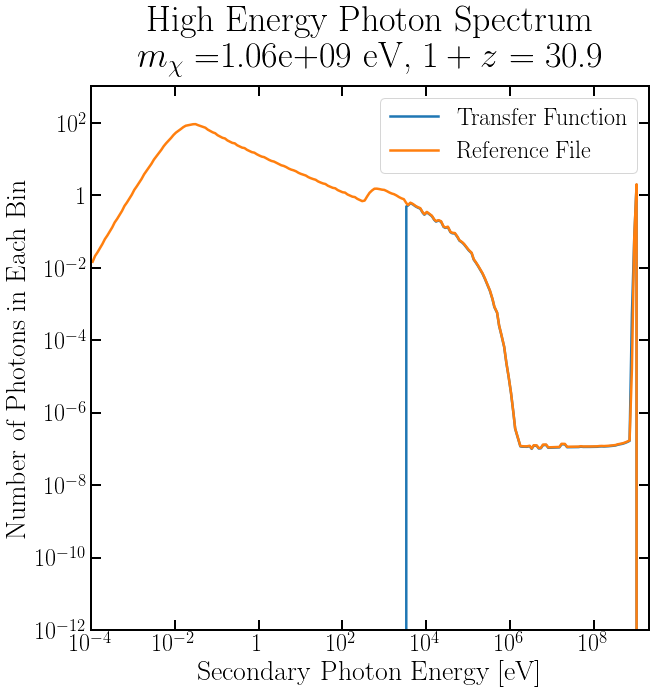

In [129]:
plt.figure()

i_plot = 1

ax = plt.gca()
tf_plot, = highengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
file_plot, = file_highengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')


plt.title('High Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mwimp_arr[eng_ind])
          +r' eV, $1+z$ = '+'{0:.1f}'.format(rs_list[i_plot])
         )

ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 2*mwimp_arr[eng_ind], 1e-12, 1e3])

[0.0001, 4000000000000.0, 1e-20, 1000000.0]

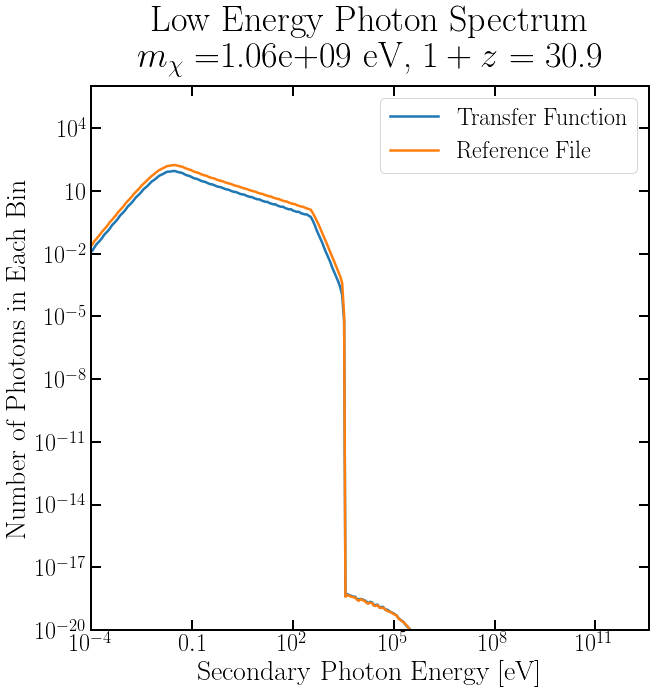

In [47]:
plt.figure()

i_plot = 1

ax = plt.gca()
tf_plot, = lowengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
file_plot, = combined_file_lowengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')

ax.set_xscale('log')
ax.set_yscale('log')

plt.title('Low Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mwimp_arr[eng_ind])
          +r' eV, $1+z$ = '+'{0:.1f}'.format(rs_list[i_plot])
         )

ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))


plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 4e12, 1e-20, 1e6])

In [58]:
a = Spectra([Spectrum(file_eng,lowengelec_spectra[i].N/(combined_file_lowengelec_spectra[i].N+1e-12), 
                      rs=rs_list[i], spec_type='N') 
     for i in np.arange(1003)])

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [66]:
lowengelec_spectra[0].N/(combined_file_lowengelec_spectra[0].N+1e-12)

array([2.03933848, 2.04763871, 2.0383271 , 2.04163243, 2.05219162,
       2.03251986, 2.05830178, 2.02896837, 2.0409612 , 2.06158814,
       2.02189205, 2.06857352, 2.01914022, 2.04066836, 2.07038079,
       2.0110358 , 2.07815523, 2.00904222, 2.08764406, 2.00741645,
       2.04089834, 2.08717018, 1.99891825, 2.09747034, 1.99807263,
       2.04179399, 2.09615195, 1.98877479, 2.10711751, 1.98906107,
       2.06188937, 2.07656615, 1.99502026, 2.11750041, 1.9805276 ,
       2.11795575, 2.00285161, 2.03691692, 2.12977161, 1.97335217,
       2.14530264, 1.97749901, 2.05433068, 2.14065949, 1.96215942,
       2.15305081, 1.96555651, 2.09396023, 2.08183607, 1.98736465,
       2.16116602, 1.95401687, 2.146052  , 2.00494674, 2.0285152 ,
       2.17028944, 1.9426197 , 2.18612309, 1.94945079, 2.06990185,
       2.16456774, 1.94014865, 2.19673392, 1.94005572, 2.12466083,
       2.08674826, 1.98161317, 2.20819555, 1.93077303, 2.18001658,
       2.01211632, 2.02630029, 2.22057981, 1.92183911, 2.23611

[0.1, 10000.0, 1e-10, 10]

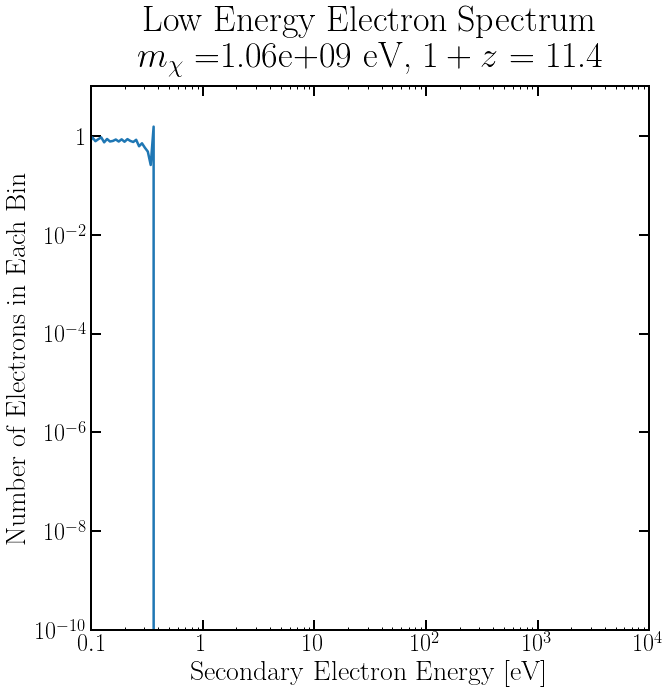

In [63]:
plt.figure()

i_plot = 500

a = Spectra([Spectrum(file_eng,lowengelec_spectra[i].N/(combined_file_lowengelec_spectra[i].N+1e-12),
                      rs=rs_list[i], spec_type='N') 
     for i in np.arange(1003)])

ax = plt.gca()
#tf_plot, = lowengelec_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
#file_plot, = combined_file_lowengelec_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
test, = a.plot(ax, ind=rs_list[i_plot], indtype='rs')
# tf_plot, = lowengelec_spectra.plot(ax, ind=rs_list[1], indtype='rs')
# file_plot, = combined_file_lowengelec_spectra.plot(ax, ind=rs_list[1], indtype='rs')

ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Low Energy Electron Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mwimp_arr[eng_ind])
          +r' eV, $1+z$ = '+'{0:.1f}'.format(rs_list[i_plot])
         )

#ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))

plt.xlabel('Secondary Electron Energy [eV]')
plt.ylabel('Number of Electrons in Each Bin')
plt.axis([1e-1, 1e4, 1e-10, 10])

In [ ]:
print(lowengelec_spectra.rs[-10:])
print(combined_file_lowengelec_spectra.rs[-10:])

In [72]:
print(sum(combined_file_lowengelec_spectra.toteng()))
print(sum(lowengelec_spectra.toteng()))

164775.2502568618
112812.10436920311


In [142]:
print(
    (sum(combined_file_lowengphot_spectra.toteng()) 
     + sum(combined_file_lowengelec_spectra.toteng()))/(
    sum(lowengphot_spectra.toteng()) + sum(lowengelec_spectra.toteng())
    )
)
print(
    sum(combined_file_lowengphot_spectra.toteng())/(
    sum(lowengphot_spectra.toteng())
    )
)

4.479474510167777
4.739524404863972


### Transfer Method Comparison: coarse rs bin check 

In [74]:
f_lists = np.zeros([max_indx+1,5,5]) # [rs, channel, coarsen]
coarse_indx = 0

In [78]:
coarse_indx = 1

In [130]:
%autoreload
m_chi = 10**eng_exp
d_lnz = 1e-3
min_indx = 0

if coarse_indx == 0:
    phot_spectra = file_lowengphot_spectra
    elec_spectra = file_lowengelec_spectra
else:
    phot_spectra = lowengphot_spectra
    elec_spectra = lowengelec_spectra

# List of redshifts from the Mathematica file
math_rs_list = np.loadtxt("/Users/"+user+"/Desktop/tmp.dat")[min_indx:]
math_rs_bounds = spectools.get_bin_bound(math_rs_list)

rs_list = phot_spectra.rs
eng = phot_spectra.eng
eng_bounds = spectools.get_bin_bound(eng)

#find index of rs in rs_list
def get_indx(rs):
    return len(rs_list) - np.searchsorted(np.flipud(rs_list), rs)

# xe as a function of redshift
xes = std_xe_interp(rs_list)

#Ensure that electron and photon spectra occur at the same redshifts
if np.any(np.abs(rs_list - elec_spectra.rs) > 1e-6):
    sys.exit()
    
# indx at which photons can photoionize
ion_indx = spectools.get_indx(eng,phys.rydberg)

# max index at which math_rs_bounds fits in rs_list
max_indx = spectools.get_indx(math_rs_list, rs_list[0])
f_list = np.zeros([max_indx+1,5])

#initialize loop
indx2 = get_indx(math_rs_bounds[0]) - 1

# Sum all spectra between redshifts rs_list[k] and rs_list[k+1]
for k in np.arange(max_indx+1):
    indx1 = get_indx(math_rs_bounds[k+1])
    
    weights = np.zeros(len(rs_list))
    weights[indx1 : indx2 + 1] = 1
    loweng_phot = phot_spectra.sum_specs(weights)
    loweng_phot.rs=1
    
    loweng_elec = elec_spectra.sum_specs(weights)
    
    #Include an energy of 10^-12 with occupation zero
    loweng_elec = Spectrum(
        np.insert(loweng_elec.eng, 0, 1e-12), np.insert(loweng_elec.N, 0, 0),
        rs=1, spec_type='N'
    )
    
    # ionized electrons
    tmp_elec = Spectrum(
        loweng_phot.eng[ion_indx:], loweng_phot.N[ion_indx:], rs=1, spec_type='N'
    )
    new_eng = tmp_elec.eng - phys.rydberg
    
    if new_eng[0] < 0:
        #Don't allow negative energies
        new_eng = np.insert(new_eng[1:], 0, 1e-12)
    tmp_elec.shift_eng(new_eng)

    # rebin so that I may add it to loweng_elec
    indx = tmp_elec.eng.size
    tmp_elec.rebin(loweng_elec.eng[:indx+1])
    loweng_elec.N[:indx+1] += tmp_elec.N
    
    # Compute Transfer Functions
    T_phot = lowE_photons.compute_dep_inj_ratio(
        loweng_phot, np.array([1-xes[k], 0, 0]), 1, 1, 'old'
    )/phys.nB/(2*m_chi+0*phys.me)

    T_elec = lowE_electrons.compute_dep_inj_ratio(
        loweng_elec, xes[k], 1, 1
    )/phys.nB/(2*m_chi+0*phys.me)
    
    f_lists[k,:,coarse_indx] = T_phot + T_elec
    
    #subtract off the CMB part contributing to continuum photons
    f_lists[k,0,coarse_indx] -= sum(file_engloss[indx1: indx2 + 1] * d_lnz /(
        phys.hubble(rs_list[indx1: indx2 + 1]) * 2 * m_chi
    ))
    
    indx2 = indx1-1
    
print('cont, exc, HI ion, He ion, heat: ',sum(f_lists[:,:,coarse_indx]))

cont, exc, HI ion, He ion, heat:  [1.14063873e-04 1.48412593e-04 2.23591643e-04 4.81501180e-06
 9.56156362e-05]


../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [131]:
old_tfs = np.loadtxt("/Users/"+user+"/Desktop/tmp"+str(eng_ind)+".dat")[min_indx:]
print(len(old_tfs))
print('mine: ',sum(sum(f_lists[:,:,coarse_indx])))
print('hers: ',sum(sum(old_tfs)))

19
mine:  0.0005864987577056982
hers:  0.002895985582767935


In [132]:
sum(sum(old_tfs))/sum(sum(f_lists[:,:,coarse_indx]))

4.9377522879956794

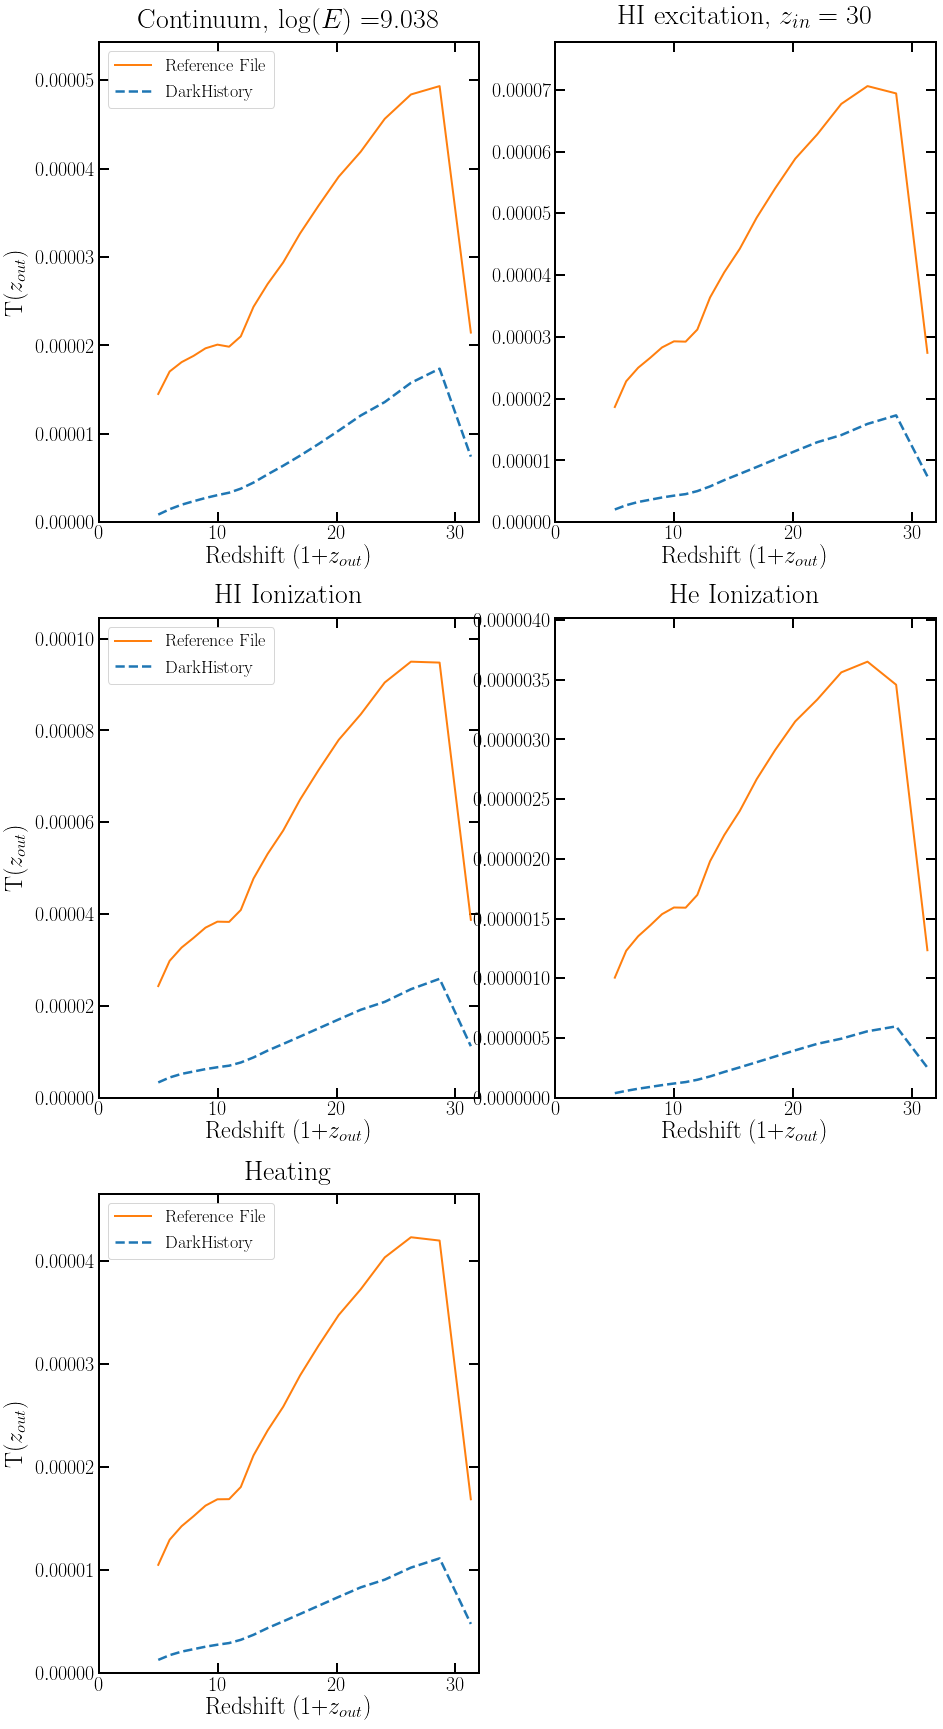

In [81]:
old_tfs = np.loadtxt("/Users/"+user+"/Desktop/tmp"+str(eng_ind)+".dat")[min_indx:]

plt.figure(figsize=(15,30))

names = ["Continuum", "HI excitation", "HI Ionization", "He Ionization", "Heating"]

for num in np.arange(5):

    ax = plt.subplot(3,2,num+1)

    old_tf_plt, = plt.plot(math_rs_list[:max_indx+1], old_tfs[:,num], 'C1', linewidth=2, label='Reference File')
    new_tf_plt0, = plt.plot(math_rs_list[:max_indx+1], f_lists[:,num,coarse_indx], 'C0--', label='DarkHistory')

    plt.tick_params(axis='both', which='major', labelsize=20)

    if num == 0:
        plt.title(names[num]+', $\\log(E) = $'+str(eng_exp), fontsize=28)
    elif num == 1:
        plt.title(names[num]+', $z_{in} = 30$', fontsize=28)
    else:
        plt.title(names[num], fontsize=28)
    plt.xlabel('Redshift (1+$z_{out}$)',fontsize=24)
    if num%2 == 0:
        plt.ylabel('T($z_{out}$)',fontsize=24)
        plt.legend(handles=[old_tf_plt, new_tf_plt0], 
            fontsize=18)
    plt.axis(
        [0, 32, 0, 1.1 * max(
            [max(f_list[:,num]),max(old_tfs[:,num])]
        )]
    )

extra = 'DarkHistory'
#plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/'+
#            'Reproducing_tFuncs_log10(E)_'+str(eng_exp)+'_'+extra+'.pdf')

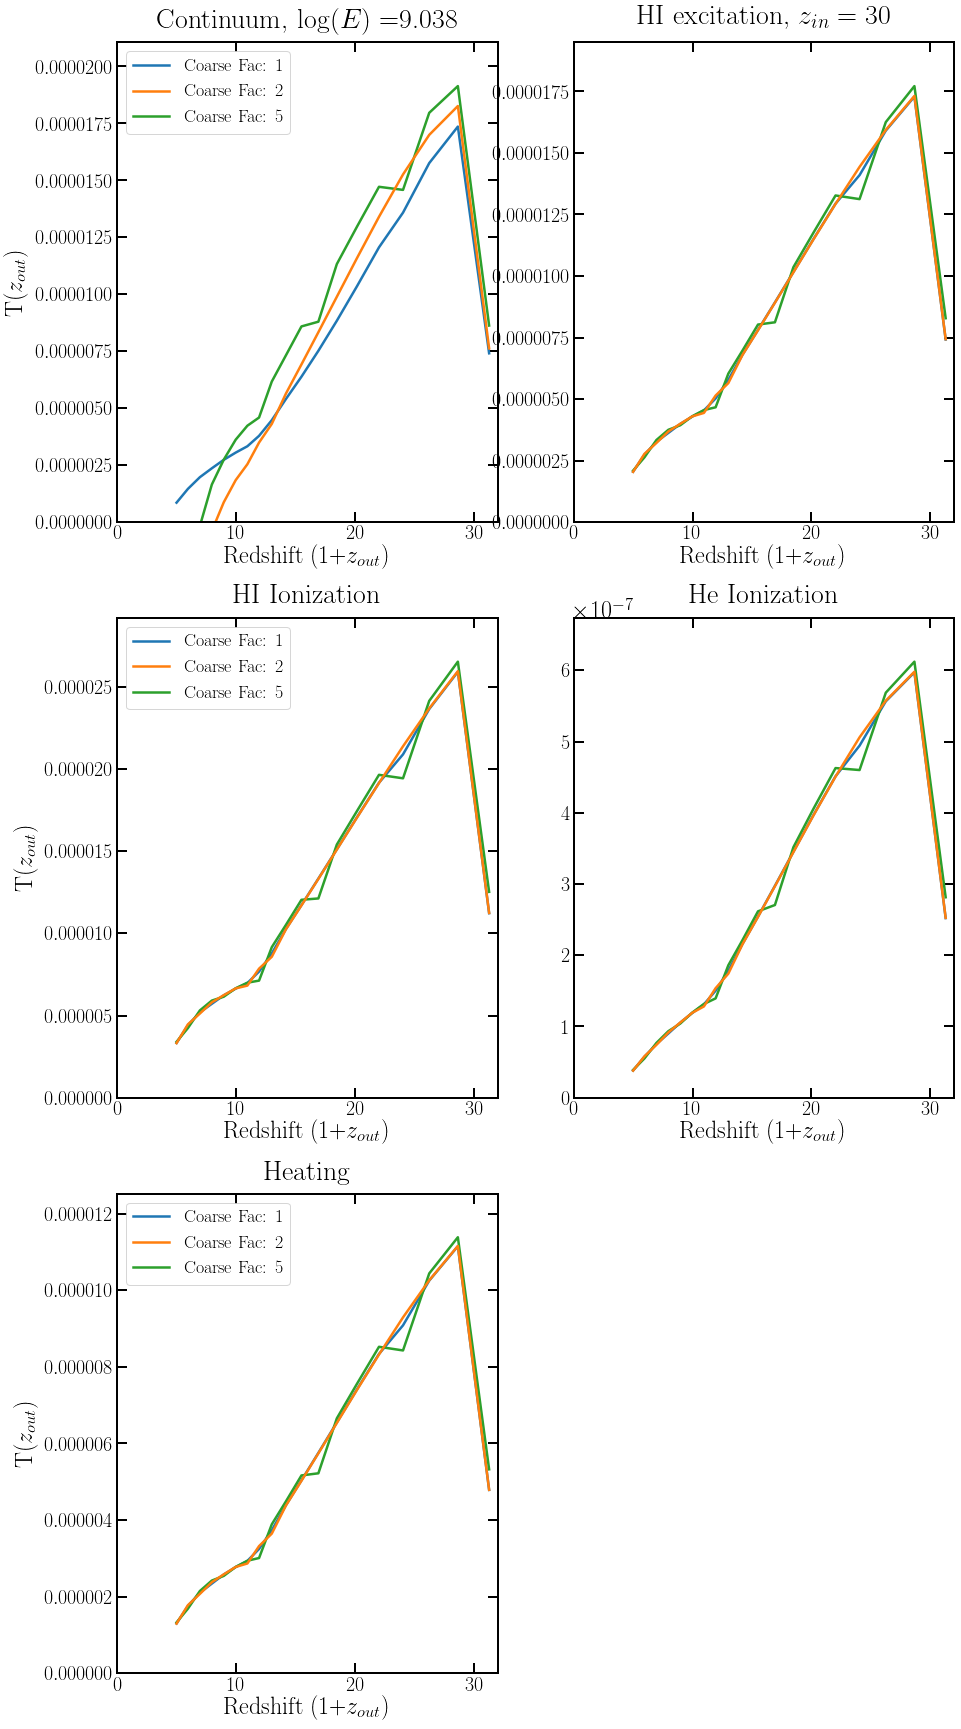

In [140]:
plt.figure(figsize=(15,30))

names = ["Continuum", "HI excitation", "HI Ionization", "He Ionization", "Heating"]

for num in np.arange(5):

    ax = plt.subplot(3,2,num+1)

    new_tf_plt0, = plt.plot(math_rs_list[:max_indx+1], f_lists[:,num,1], 'C0', label='Coarse Fac: 1')
    new_tf_plt1, = plt.plot(math_rs_list[:max_indx+1], f_lists[:,num,2], 'C2', label='Coarse Fac: 5')
    new_tf_plt2, = plt.plot(math_rs_list[:max_indx+1], f_lists[:,num,4], 'C1', label='Coarse Fac: 2')

    plt.tick_params(axis='both', which='major', labelsize=20)

    if num == 0:
        plt.title(names[num]+', $\\log(E) = $'+str(eng_exp), fontsize=28)
    elif num == 1:
        plt.title(names[num]+', $z_{in} = 30$', fontsize=28)
    else:
        plt.title(names[num], fontsize=28)
    plt.xlabel('Redshift (1+$z_{out}$)',fontsize=24)
    if num%2 == 0:
        plt.ylabel('T($z_{out}$)',fontsize=24)
        plt.legend(handles=[new_tf_plt0, new_tf_plt2, new_tf_plt1], 
            fontsize=18)
    plt.axis(
        [0, 32, 0, 1.1 * max(
            [max(f_lists[:,num, 1]),max(f_lists[:,num, 2])]
        )]
    )

extra = 'DarkHistory'
plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/'+
            'coarseningComparisons.pdf')

In [ ]:
f_lists = np.zeros([max_indx+1,5,5]) # [rs, channel, coarsen]
f_lists[:,:,0] = f_list

In [ ]:
%autoreload
m_chi = 10**eng_exp
d_lnz = 1e-3
min_indx = 0


# List of redshifts from the Mathematica file
math_rs_list = np.loadtxt("/Users/"+user+"/Desktop/tmp.dat")[min_indx:]
math_rs_bounds = spectools.get_bin_bound(math_rs_list)

rs_list = lowengphot_spectra.rs
eng = lowengphot_spectra.eng
eng_bounds = spectools.get_bin_bound(eng)

# xe as a function of redshift
xes = std_xe_interp(rs_list)

#Ensure that electron and photon spectra occur at the same redshifts
if np.any(np.abs(rs_list - lowengelec_spectra.rs) > 1e-6): ###
    sys.exit()
    
# indx at which photons can photoionize
ion_indx = spectools.get_indx(eng,phys.rydberg)

# max index at which math_rs_bounds fits in rs_list
max_indx = spectools.get_indx(math_rs_list, rs_list[0])

#initialize loop
indx2 = len(rs_list) - np.searchsorted(np.flipud(rs_list), math_rs_bounds[0]) - 1

# Sum all spectra between redshifts rs_list[k] and rs_list[k+1]
for k in np.arange(max_indx+1):
    indx1 = len(rs_list) - np.searchsorted(np.flipud(rs_list), math_rs_bounds[k+1])
    
    weights = np.zeros(len(rs_list))
    weights[indx1 : indx2 + 1] = 1
    loweng_phot = lowengphot_spectra.sum_specs(weights) ###
    loweng_phot.rs=1
    
    loweng_elec = lowengelec_spectra.sum_specs(weights) ###
    
    #Include an energy of 10^-12 with occupation zero
    loweng_elec = Spectrum(
        np.insert(loweng_elec.eng, 0, 1e-12), np.insert(loweng_elec.N, 0, 0),
        rs=1, spec_type='N'
    )
    
    # ionized electrons
    tmp_elec = Spectrum(
        loweng_phot.eng[ion_indx:], loweng_phot.N[ion_indx:], rs=1, spec_type='N'
    )
    new_eng = tmp_elec.eng - phys.rydberg
    
    if new_eng[0] < 0:
        #Don't allow negative energies
        new_eng = np.insert(new_eng[1:], 0, 1e-12)
    tmp_elec.shift_eng(new_eng)

    # rebin so that I may add it to loweng_elec
    indx = tmp_elec.eng.size
    tmp_elec.rebin(loweng_elec.eng[:indx+1])
    loweng_elec.N[:indx+1] += tmp_elec.N
    
    # Compute Transfer Functions
    T_phot = lowE_photons.compute_dep_inj_ratio(
        loweng_phot, np.array([1-xes[k], 0, 0]), 1, 1, 'old'
    )/phys.nB/(2*m_chi+0*phys.me)

    T_elec = lowE_electrons.compute_dep_inj_ratio(
        loweng_elec, xes[k], 1, 1
    )/phys.nB/(2*m_chi+0*phys.me)
    
    f_lists[k,:,coarse_indx] = T_phot + T_elec
    
    #subtract off the CMB part contributing to continuum photons
    f_lists[k,0,coarse_indx] -= sum(file_engloss[indx1: indx2 + 1] * d_lnz /(
        phys.hubble(rs_list[indx1: indx2 + 1]) * 2 * m_chi
    ))
    
    indx2 = indx1-1
    
print('cont, exc, HI ion, He ion, heat: ',sum(f_lists[:,:,coarse_indx]))

In [ ]:
old_tfs = np.loadtxt("/Users/"+user+"/Desktop/tmp"+str(eng_ind)+".dat")[min_indx:]
print(len(old_tfs))
print('mine: ',sum(sum(f_lists[:,:,coarse_indx])))
print('hers: ',sum(sum(old_tfs)))

In [ ]:
old_tfs = np.loadtxt("/Users/"+user+"/Desktop/tmp"+str(eng_ind)+".dat")[min_indx:]

plt.figure(figsize=(15,30))

names = ["Continuum", "HI excitation", "HI Ionization", "He Ionization", "Heating"]

for num in np.arange(5):

    ax = plt.subplot(3,2,num+1)

    old_tf_plt, = plt.plot(math_rs_list[:max_indx+1], old_tfs[:,num], linewidth=2, label='Reference File')
    new_tf_plt0, = plt.plot(math_rs_list[:max_indx+1], f_lists[:,num,0], 'C1--', label='Coarsen Fac: 1')
    #new_tf_plt1, = plt.plot(math_rs_list[:max_indx+1], f_lists[:,num,1], 'C2--', label='Coarsen Fac: 5')

    #ax.set_xscale('log')
    #ax.set_yscale('log')

    plt.tick_params(axis='both', which='major', labelsize=20)

    if num == 0:
        plt.title(names[num]+', $\\log(E) = $'+str(eng_exp), fontsize=28)
    elif num == 1:
        plt.title(names[num]+', $z_{in} = 30$', fontsize=28)
    else:
        plt.title(names[num], fontsize=28)
    plt.xlabel('Redshift (1+$z_{out}$)',fontsize=24)
    if num%2 == 0:
        plt.ylabel('T($z_{out}$)',fontsize=24)
        plt.legend(handles=[old_tf_plt, new_tf_plt0],#, new_tf_plt1], 
            fontsize=18)
    plt.axis(
        [0, 32, 0, 1.1 * max(
            [max(f_lists[:,num,coarse_indx]),max(old_tfs[:,num])]
        )]
    )

extra = 'DarkHistory'
#plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/'+
#            'Reproducing_tFuncs_log10(E)_'+str(eng_exp)+'_'+extra+'.pdf')

### Scratch

In [ ]:
#Checking If cubic spline messes up extrapolation

tmp = np.log10(
    [[0.308926,        0.458301,        0.020497,        1e-10,        0.212276],
    [0.305493,        0.311491,        0.236187,        0.001360,        0.145469],
    [0.206100,        0.334449,        0.298747,        0.006573,        0.154130],
    [0.182742,        0.326805,        0.335376,        0.010336,        0.144741],
    [0.162580,        0.322660,        0.354960,        0.016320,        0.143480],
    [0.151880,        0.323526,        0.358025,        0.024367,        0.142202]]
)
engs = np.log10([14, 30, 60, 100, 300, 3000])
num = 3

from scipy import interpolate
f = interpolate.interp1d(
    engs, tmp[:,num], kind='linear', bounds_error=False, fill_value=(tmp[0,num],tmp[5,num])
)

x = np.log10(np.arange(5, 4000, .5))
y = f(x)
plt.plot(engs, tmp[:,num], 'o', x, y, '-')
plt.show()

In [ ]:
num=0
indx1 = len(rs_list) - np.searchsorted(np.flipud(rs_list), math_rs_bounds[num+1])
print(indx1)
indx2 = len(rs_list) - np.searchsorted(np.flipud(rs_list), math_rs_bounds[num]) - 1
print(math_rs_bounds[num],' ', rs_list[indx2:indx2+2],' ', rs_list[indx1-1:indx1+1]
      ,' ', math_rs_bounds[num+1])

In [ ]:
# This is dE/dt, multiply by dt/2m_xchi
eng = file_lowengphot_spectra.eng
eng_bounds = spectools.get_bin_bound(eng)
T = phys.TCMB(3)
def CMB_dNdE(eng):
    return phys.CMB_spec(eng,T)

##Compute CMB part of the spectrum that must be subtracted
    #T = phys.TCMB(rs_list[k])
    #CMB_loss_spec = spectools.discretize(eng_bounds, CMB_dNdE)
    #CMB_loss_spec.N *= file_engloss[k] * phys.dtdz(rs_list[k]) *(
    #    math_rs_bounds[k+1] - math_rs_bounds[k]
    #    )/2/m_chi
    
    #loweng_phot.N -= CMB_loss_spec.N[:-1]

CMB_loss = file_engloss[3]*spectools.discretize(eng_bounds, CMB_dNdE)
print(CMB_loss.toteng())

In [ ]:
num=10
print(math_rs_bounds[max_indx:max_indx+2])
#print(file_lowengphot_spectra[num].N[:max_indx+2])
print('rs: ', rs_list[num], '\n', file_lowengphot_spectra[num].N, '\n\n',
      file_lowengelec_spectra[num].N)